In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from scipy.stats import ttest_ind, levene

sns.set_style("whitegrid")
%matplotlib inline 
#Ensures that plots are displayed within the notebook.

In [2]:
# Define paths for training and validation data
data_dir = "/home/hpc/iwfa/iwfa110h/Uddipan/regression_task_uddipan/Data/LinearWinding/dataset_linear_winding_multimodal"
train_subset = "train_val"
train_csv_file_path = os.path.join(data_dir, train_subset, "labels_and_metadata_coil_level_train_val_2023-09-15.CSV")


try:
    df = pd.read_csv(train_csv_file_path)
    print("CSV File loaded")
except FileNotFoundError: #This block catches the FileNotFoundError
    print(f"File not found at path :{train_csv_file_path}")
    raise # Re-raises the caught exception. This means after printing the custom message, the original FileNotFoundError is thrown again
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")
    raise

CSV File loaded


In [3]:
required_columns = ['coil_id', 'material_batch', 'label_dc_resistance']
df = df[required_columns]

# Display the first few rows of the data
print("First few rows of the data:")
display(df.head())
print("Last few rows of the data:")
display(df.tail())


First few rows of the data:


,coil_id,material_batch,label_dc_resistance
0,coil_001,1,2.5541
1,coil_002,1,2.5743
2,coil_004,1,2.5567
3,coil_006,1,2.5549
4,coil_007,1,2.5506


Last few rows of the data:


,coil_id,material_batch,label_dc_resistance
581,coil_726,2,2.6193
582,coil_727,2,2.6133
583,coil_728,2,2.6235
584,coil_729,2,2.6163
585,coil_730,2,2.6182


FORCE CURVE

In [4]:
def load_force_values(pkl_path):
    """
    Loads a pickle file and extracts the 'force' values.

    Parameters:
        pkl_path (str): Path to the .pkl file.

    Returns:
        force_values (list or pd.Series): The extracted force values.
    """
    try:
        with open(pkl_path, 'rb') as file:
            data = pickle.load(file)
        
        # If the pickle is a DataFrame
        if isinstance(data, pd.DataFrame):
            if 'force' in data.columns:
                return data['force'].tolist()
            else:
                print(f"'force' column not found in DataFrame: {pkl_path}")
                return None
        
        # If the pickle is a dictionary
        elif isinstance(data, dict):
            if 'force' in data:
                return data['force']
            else:
                print(f"'force' key not found in dictionary: {pkl_path}")
                return None
        
        # If the pickle is a custom object with 'force' attribute
        elif hasattr(data, 'force'):
            return data.force
        
        else:
            print(f"Unknown data structure in pickle file: {pkl_path}")
            return None

    except FileNotFoundError:
        print(f"Pickle file not found: {pkl_path}")
        return None
    except Exception as e:
        print(f"Error loading pickle file {pkl_path}: {e}")
        return None


In [5]:
# Initialize dictionaries to store force values for each batch
force_data_batch_1 = {}
force_data_batch_2 = {}


In [6]:
# Iterate through each row with a progress bar
for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing coils"):
    coil_id = row['coil_id']
    material_batch = row['material_batch']
    subset = train_subset  # As defined earlier
    pkl_filename = f"{coil_id}_force_and_displacement_curves.pkl"
    curve_file_path = os.path.join(data_dir, subset, coil_id, pkl_filename)
    
    # Load force values
    force_values = load_force_values(curve_file_path)
    
    # Assign to the respective batch dictionary if force_values are present
    if force_values is not None:
        if material_batch == 1:
            force_data_batch_1[coil_id] = force_values
        elif material_batch == 2:
            force_data_batch_2[coil_id] = force_values
        else:
            print(f"Unknown material_batch {material_batch} for coil_id {coil_id}")


Processing coils: 100%|██████████| 586/586 [00:06<00:00, 88.99it/s] 


In [7]:
import pandas as pd

# Function to create a detailed DataFrame
def create_detailed_dataframe(force_dict):
    """
    Converts a force data dictionary into a pandas DataFrame with coil_id and force columns.
    
    Parameters:
        force_dict (dict): Dictionary with coil_id as keys and lists of force values as values.
    
    Returns:
        df (pd.DataFrame): DataFrame with 'coil_id' and 'force' columns.
    """
    # Initialize empty lists
    coil_ids = []
    forces = []
    
    # Populate the lists
    for coil_id, force_list in force_dict.items():
        coil_ids.extend([coil_id] * len(force_list))
        forces.extend(force_list)
    
    # Create DataFrame
    df = pd.DataFrame({
        'coil_id': coil_ids,
        'force': forces
    })
    
    return df

# Usage
detailed_df_batch_1 = create_detailed_dataframe(force_data_batch_1)
detailed_df_batch_2 = create_detailed_dataframe(force_data_batch_2)


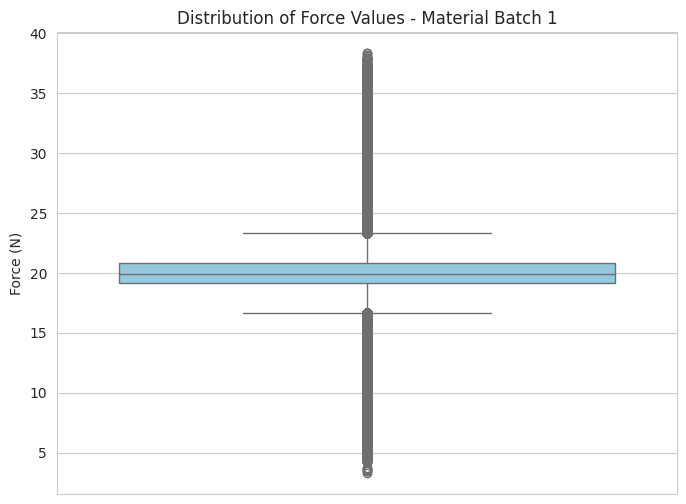

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(y=detailed_df_batch_1['force'], color='skyblue')
plt.title('Distribution of Force Values - Material Batch 1')
plt.ylabel('Force (N)')
plt.show()


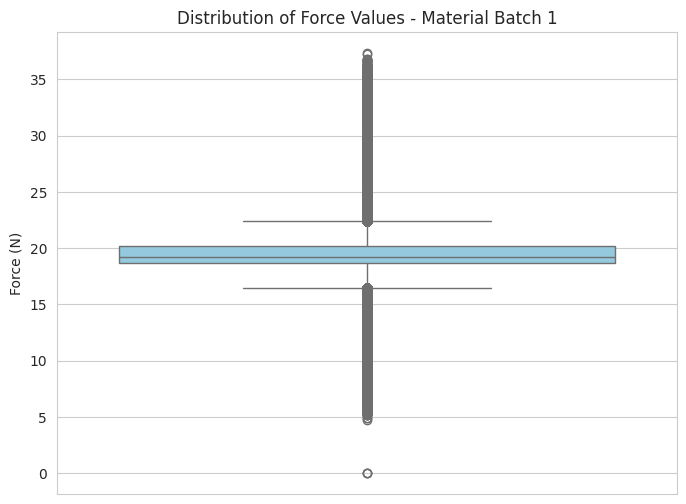

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(y=detailed_df_batch_2['force'], color='skyblue')
plt.title('Distribution of Force Values - Material Batch 1')
plt.ylabel('Force (N)')
plt.show()


/tmp/ipykernel_3267613/1426389185.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='coil_id', y='force', data=sample_df, palette='Set3')


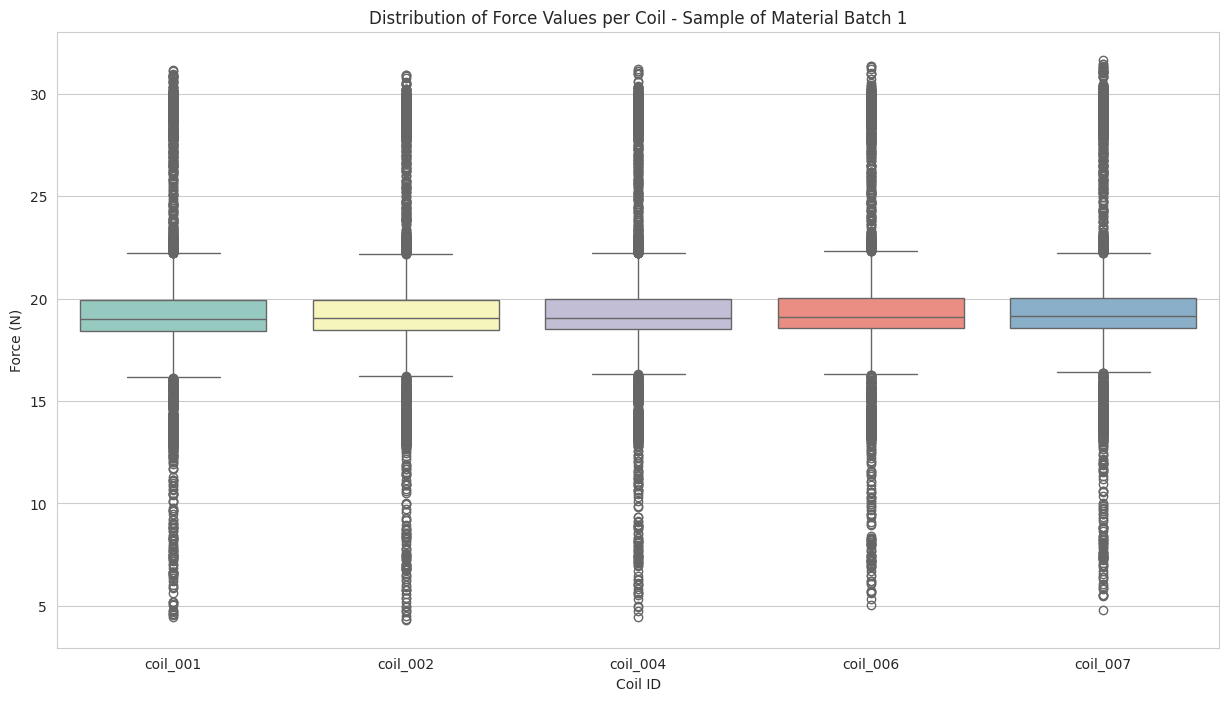

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example with 5 coils
sample_coils = detailed_df_batch_1['coil_id'].unique()[:5]  # Select first 5 coils
sample_df = detailed_df_batch_1[detailed_df_batch_1['coil_id'].isin(sample_coils)]

plt.figure(figsize=(15, 8))
sns.boxplot(x='coil_id', y='force', data=sample_df, palette='Set3')
plt.title('Distribution of Force Values per Coil - Sample of Material Batch 1')
plt.xlabel('Coil ID')
plt.ylabel('Force (N)')
plt.show()


In [11]:
# Function to compute multiple statistics
def compute_force_features(force_dict):
    """
    Computes multiple statistical features for each coil.

    Parameters:
        force_dict (dict): Dictionary with coil_id as keys and list of force values as values.

    Returns:
        features_df (pd.DataFrame): DataFrame containing statistical features for each coil.
    """
    features = {
        'mean_force': [],
        'median_force': [],
        'std_force': [],
        'min_force': [],
        'max_force': [],
        '25th_percentile': [],
        '75th_percentile': []
    }
    coil_ids = []
    
    for coil_id, forces in force_dict.items():
        coil_ids.append(coil_id)
        features['mean_force'].append(np.mean(forces))
        features['median_force'].append(np.median(forces))
        features['std_force'].append(np.std(forces, ddof=1))
        features['min_force'].append(np.min(forces))
        features['max_force'].append(np.max(forces))
        features['25th_percentile'].append(np.percentile(forces, 25))
        features['75th_percentile'].append(np.percentile(forces, 75))
    
    features_df = pd.DataFrame(features, index=coil_ids).reset_index()
    features_df = features_df.rename(columns={'index': 'coil_id'})
    return features_df

# Compute features for both batches
features_batch_1 = compute_force_features(force_data_batch_1)
features_batch_2 = compute_force_features(force_data_batch_2)

# Merge with resistance
merged_features_batch_1 = pd.merge(features_batch_1, df[['coil_id', 'label_dc_resistance']], on='coil_id', how='left')
merged_features_batch_2 = pd.merge(features_batch_2, df[['coil_id', 'label_dc_resistance']], on='coil_id', how='left')

# Display first few rows
print("First few rows of merged features - Batch 1:")
display(merged_features_batch_1.head())

print("\nFirst few rows of merged features - Batch 2:")
display(merged_features_batch_2.head())


First few rows of merged features - Batch 1:


,coil_id,mean_force,median_force,std_force,min_force,max_force,25th_percentile,75th_percentile,label_dc_resistance
0,coil_001,19.317325,19.010000,1.577285,4.46,31.139999,18.430000,19.940001,2.5541
1,coil_002,19.338130,19.049999,1.563745,4.32,30.940001,18.459999,19.950001,2.5743
2,coil_004,19.384552,19.070000,1.554278,4.47,31.190001,18.520000,20.000000,2.5567
3,coil_006,19.411695,19.110001,1.553561,5.03,31.379999,18.540001,20.049999,2.5549
4,coil_007,19.434810,19.170000,1.550517,4.80,31.670000,18.580000,20.040001,2.5506



First few rows of merged features - Batch 2:


,coil_id,mean_force,median_force,std_force,min_force,max_force,25th_percentile,75th_percentile,label_dc_resistance
0,coil_214,19.457028,19.190001,1.582558,7.03,32.919998,18.610001,20.070000,2.6164
1,coil_216,19.441428,19.139999,1.601738,7.00,32.549999,18.570000,20.090000,2.6066
2,coil_217,19.435260,19.139999,1.605593,7.05,33.020000,18.540001,20.059999,2.6080
3,coil_218,19.433564,19.120001,1.592831,7.37,32.590000,18.570000,20.070000,2.6114
4,coil_219,19.427665,19.150000,1.604604,4.85,34.349998,18.570000,20.040001,2.6088
